## Directory Structure
PLEASE make sure your directory looks like this:
- root_dir
    - pixel-nerf (clone/pull from github)
    - adaptive-volume-rendering (clone/pull from github)
        - 6S980_Project.ipynb
    - scene-representation-networks (clone/pull from github)
    - data
    - checkpoints
    - ......
    
Then set your pwd to root_dir

## Relevant Repos

- PixelNeRF repo: https://github.com/sxyu/pixel-nerf

- SRN repo: https://github.com/vsitzmann/scene-representation-networks

- SRN raymarcher algorithm: https://github.com/vsitzmann/scene-representation-networks/blob/master/custom_layers.py

## Data

- Currently using cars dataset from SRN

## What we did

- Yanke: Now all helper functions are in the github repo
- Yanke: Modified data shape so that they are compatible with PixelNeRF


## TODO
- Missing trainer (can borrow some from HW3)
- Now normal renderer is just simple evenly sample. Need to add importance weighting later.

In [2]:
root_dir = "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"       # This is the only thing you need to change.
%cd "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"

# Install everything
!rm -r adaptive_volume_rendering
!rm -r pixel_nerf

%pip install -r adaptive-volume-rendering/requirements.txt

# The below remaining is for us to import packages ('-' does not work)
!cp -r adaptive-volume-rendering adaptive_volume_rendering
!cp -r pixel-nerf pixel_nerf

# Go to working dir

working_dir = f"{root_dir}/adaptive_volume_rendering/"

/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project
rm: adaptive_volume_rendering: No such file or directory
rm: pixel_nerf: No such file or directory
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import everything
import sys
sys.path.insert(0, f"{root_dir}/pixel_nerf/src/")
from adaptive_volume_rendering.src.utils.utils import *
from adaptive_volume_rendering.src.data.dataset import *
from pixel_nerf.src.model import make_model, loss
from pixel_nerf.src.render import NeRFRenderer
from pixel_nerf.src.data import get_split_dataset
from pixel_nerf.src.util import util


print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installed Torch version: 1.13.0
cpu


## Setup & Load Test Data

mkdir: data: File exists
mkdir: checkpoints: File exists


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


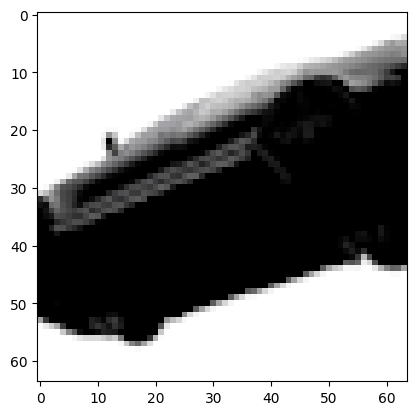

Cam2world  tensor([[ 5.2892e-01,  5.0751e-01,  6.8020e-01, -8.8427e-01],
        [-8.4867e-01,  3.1630e-01,  4.2392e-01, -5.5110e-01],
        [-1.1921e-07, -8.0149e-01,  5.9801e-01, -7.7741e-01],
        [-0.0000e+00,  0.0000e+00, -0.0000e+00,  1.0000e+00]])
Intrinsics  tensor([[1.0254, 0.0000, 0.5000],
        [0.0000, 1.0254, 0.5000],
        [0.0000, 0.0000, 1.0000]])
Pixel coords shape torch.Size([4096, 2]) tensor(0.7480)
Scene idx tensor([1272])


In [4]:
# Download data and weights

# Make a new directory
!mkdir data
!mkdir checkpoints

# Download Test Dataset
if not os.path.exists(f"{root_dir}data/cars_train.hdf5"):
    # Download SRNs-cars dataset
    gdown.download("https://drive.google.com/uc?id={}".format("1SBjlsizq0sFNkCZxMQh-pNRi0HyFozKb"),f"{root_dir}data/cars_train.hdf5")

# View test image
sl = 64
dataset = SRNsCars(root_dir,img_sidelength=sl)
mi, rgb = next(iter(dataset))

rgb = rgb.reshape(sl, sl, 3).view()

plt.imshow(rgb)
plt.show()

print("Cam2world ", mi['cam2world'])
print("Intrinsics ", mi['intrinsics'])
print("Pixel coords shape", mi['x_pix'].shape, mi['x_pix'].max())
print("Scene idx", mi['idx'])

## Download pretrained weights from PixelNeRF
if not os.path.exists(f"{root_dir}checkpoints/pixel_nerf_weights.zip"):
  gdown.download("https://drive.google.com/uc?id={}".format("1UO_rL201guN6euoWkCOn-XpqR2e8o6ju"),f"{root_dir}checkpoints/pixel_nerf_weights.zip")
  !unzip checkpoints/pixel_nerf_weights.zip -d checkpoints/

## Renderer

Loading PixlNeRF models

- The volume renderer is in src/nerf.py
- Can easily wrap a net with a renderer using _RenderWrapper function
- The current volume renderer samples points in the following way:
  - Sample 64 coarse points (uniform sample)
  - Sample 16 fine points (importance sample, still need to check how)
  - Compute an expected depth, then sample 16 random normal points with sd=0.01 around that depth.

In [6]:
# Create a custom conf
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"{working_dir}conf/default_mv.conf")

# Create a scene representation net
net = make_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True
#net.encoder.eval()



Using torchvision resnet34 encoder


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
######## TODO
# Create a renderer
renderer = NeRFRenderer.from_conf(conf["renderer"]).to(
    device=device
)